# Quantiacs Toolbox Sample: Support Vector Machine
This tutorial will show you how to use svm with the Quantiacs Toolbox to predict the next day's trend.  
We will use the closing price of the last week (5 days) as features and the trend of the next day as a value.  
For each prediction, we will use one year (252 days) of lookback data. 

In [1]:
import quantiacsToolbox
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import svm
%matplotlib inline

In [2]:
%%html
<style>
table {float:left}
</style>

For developing and testing a strategy, we will use the raw data in the tickerData folder that has been downloaded via the Toolbox's loadData() function.
  
This is just a simple sample to show how svm works.  
Extract the closing price of the Australian Dollar future (F_AD) for the past year:

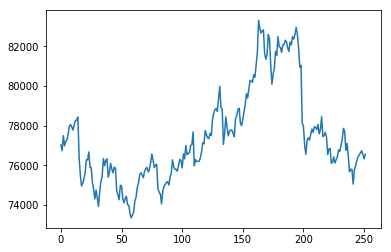

In [3]:
F_AD = pd.read_csv('./tickerData/F_AD.txt')
CLOSE = np.array(F_AD.loc[:252-1, [' CLOSE']])
plt.plot(CLOSE)

## Now we can create samples.  
Use the last 5 days' close price as features.  
We will use a binary trend: y = 1 if price goes up, y = -1 if price goes down  
  
For example, given the close price on 19900114:  

| DATE | CLOSE |     
| :--- |------ |
| 19900110 | 77580.0 |
| 19900111 | 77980.0 |
| 19900112 | 78050.0 |
| 19900113 | 77920.0 |
| 19900114 | 77770.0 |
| 19900115 | 78060.0 |

Corresponding sample should be  
x = (77580.0, 77980.0, 78050.0, 77920.0, 77770.0)  
y = 1  

In [4]:
X = np.concatenate([CLOSE[i:i+5] for i in range(252-5)], axis=1).T
y = np.sign((CLOSE[5:] - CLOSE[5-1: -1]).T[0])

#### Use svm to learn and predict:

In [5]:
clf = svm.SVC()
clf.fit(X, y)
clf.predict(CLOSE[-5:].T)

array([ 1.])

#### 1 shows that the close price will go up tomorrow.  
#### What is the real value?

In [6]:
F_AD.loc[251:252, ['DATE', ' CLOSE']]

,DATE,CLOSE
251,19901228,76550.0
252,19901231,76560.0


#### Hooray! Our strategy successfully predicted the trend.  
#### Now we use the Quantiacs Toolbox to run our strategy.

In [7]:
class myStrategy(object):

    def myTradingSystem(self, DATE, OPEN, HIGH, LOW, CLOSE, VOL, OI, P, R, RINFO, exposure, equity, settings):
        """
        For 4 lookback days and 3 markets, CLOSE is a numpy array looks like
        [[ 12798.   11537.5   9010. ]
         [ 12822.   11487.5   9020. ]
         [ 12774.   11462.5   8940. ]
         [ 12966.   11587.5   9220. ]]
        """

        # define helper function
        # use close price predict the trend of the next day
        def predict(CLOSE, gap):
            lookback = CLOSE.shape[0]
            X = np.concatenate([CLOSE[i:i + gap] for i in range(lookback - gap)], axis=1).T
            y = np.sign((CLOSE[gap:lookback] - CLOSE[gap - 1:lookback - 1]).T[0])
            y[y==0] = 1

            clf = svm.SVC()
            clf.fit(X, y)

            return clf.predict(CLOSE[-gap:].T)

        nMarkets = len(settings['markets'])
        gap = settings['gap']

        pos = np.zeros((1, nMarkets), dtype='float')
        for i in range(nMarkets):
            try:
                pos[0, i] = predict(CLOSE[:, i].reshape(-1, 1),
                                    gap, )

            # for NaN data set position to 0
            except ValueError:
                pos[0, i] = 0.

        return pos, settings


    def mySettings(self):
        """ Define your trading system settings here """

        settings = {}

        # Futures Contracts
        settings['markets'] = ['CASH', 'F_AD', 'F_BO', 'F_BP', 'F_C', 'F_CC', 'F_CD',
                               'F_CL', 'F_CT', 'F_DX', 'F_EC', 'F_ED', 'F_ES', 'F_FC', 'F_FV', 'F_GC',
                               'F_HG', 'F_HO', 'F_JY', 'F_KC', 'F_LB', 'F_LC', 'F_LN', 'F_MD', 'F_MP',
                               'F_NG', 'F_NQ', 'F_NR', 'F_O', 'F_OJ', 'F_PA', 'F_PL', 'F_RB', 'F_RU',
                               'F_S', 'F_SB', 'F_SF', 'F_SI', 'F_SM', 'F_TU', 'F_TY', 'F_US', 'F_W', 'F_XX',
                               'F_YM']

        settings['lookback'] = 252
        settings['budget'] = 10 ** 6
        settings['slippage'] = 0.05

        settings['gap'] = 5

        return settings

Loading Data...
Done! 
Evaluating Trading System


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/quantiacsToolbox/quantiacsToolbox.py:428: RuntimeWarning: invalid value encountered in divide
  position = position/np.sum(abs(position))


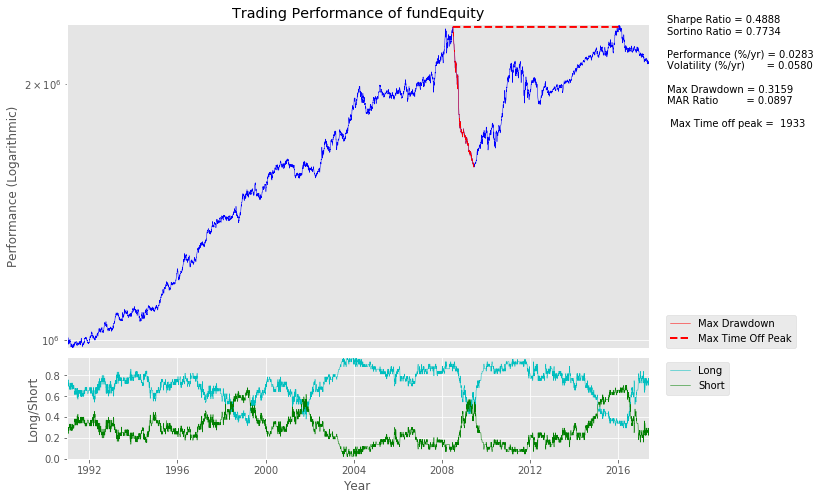

In [8]:
result = quantiacsToolbox.runts(myStrategy)

** Congrats! You just finished your first svm strategy.**  

Try to optimize it!  

**Quantiacs https://www.quantiacs.com/**